# Is podium


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier, XGBRegressor, XGBRanker

import sys

sys.path.append("..")

from utils.visualization import model_selection
from utils.custom_cvs import VariableTimeSeriesSplit
from utils.custom_scorers import (
    balanced_accuracy_score,
    balanced_accuracy_ranker,
)

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Initialization


We continue with the selection of the model that predicts the podium


In [2]:
df = pd.read_csv("../assets/data/processed/other_models.csv")

mid_rc = df.groupby("raceYear")["raceRound"].max().to_numpy() // 2
get_half = lambda x: f'{x["raceYear"]}{x["raceRound"] <= mid_rc[x["raceYear"] - 2006]}'
instances_per_half = df.apply(get_half, axis=1).value_counts(sort=False).to_numpy()

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})

X = pd.read_csv("../assets/data/processed/other_models_X.csv")
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: int(x["driverRef"] in x["driverRefPodium"]), axis=1)

## XGBClassifier


PI: 0.776 with (0, 1, 2, 3, 4, 5, 6, 8, 9, 15, 17, 18, 20, 21, 22, 23, 24) ==
	('carNumber', 'circuitLng', 'constructorNationality', 'constructorRef',
	'constructorWins', 'driverAgeAtRace', 'driverAgeToday', 'driverNationality',
	'driverNumber', 'driverRef', 'driverWins', 'grandPrix', 'positionGrid', 'q2', 'q3',
	'qid', 'raceRound')
SFS: 0.801 with (0, 1, 3, 5, 12, 18, 21, 23) == ('carNumber', 'positionGrid',
	'driverNumber', 'constructorRef', 'circuitLocation', 'constructorWins', 'q3',
	'driverAgeAtRace')
GA: 0.789 with (1, 3, 5, 7, 8, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23) ==
	('positionGrid', 'driverNumber', 'constructorRef', 'raceYear', 'raceRound',
	'circuitRef', 'circuitLocation', 'circuitCountry', 'circuitLat', 'circuitLng',
	'circuitAlt', 'constructorWins', 'q1', 'driverAgeToday', 'driverAgeAtRace')


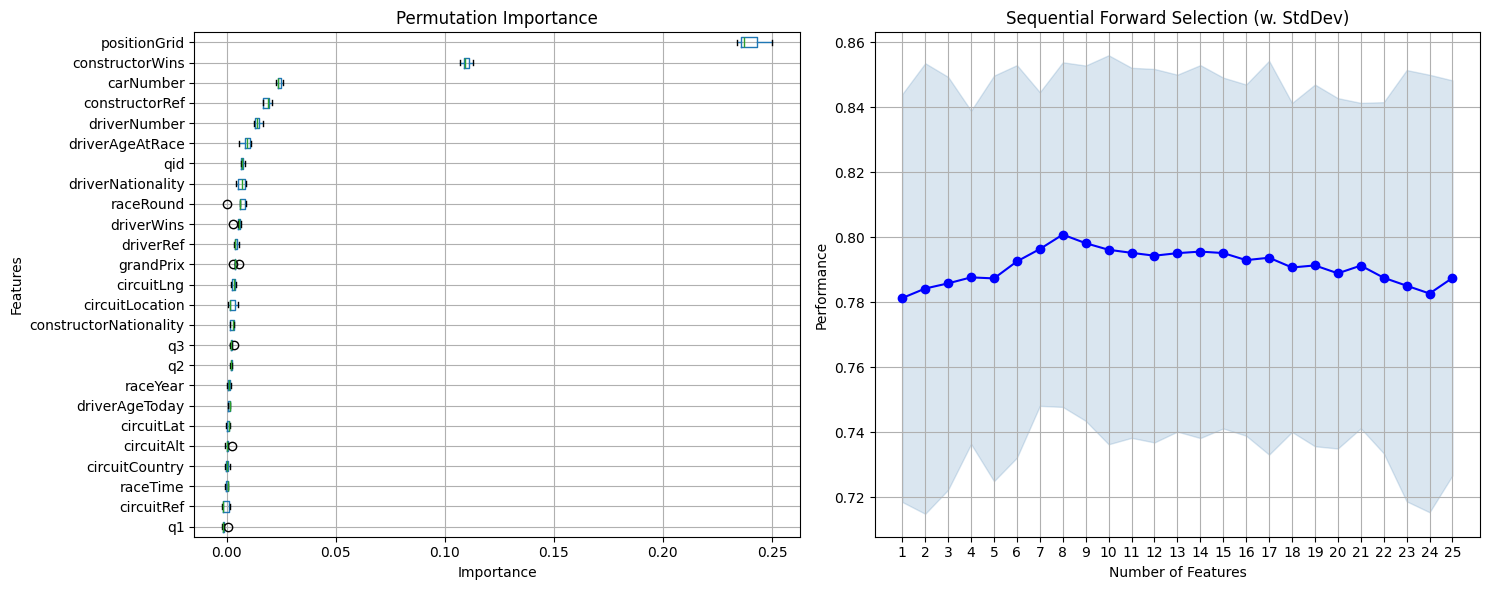

In [3]:
xgbc = XGBClassifier(
    objective="binary:logistic",
    subsample=0.75,
    reg_lambda=10,
    reg_alpha=3,
    n_estimators=75,
    min_child_weight=5,
    max_depth=3,
    learning_rate=0.2,
    gamma=0.5,
    colsample_bytree=0.75,
)
scoring = make_scorer(balanced_accuracy_score)
model_selection(xgbc, X, y, tscv, scoring)

## XGBRegressor


PI: 0.778 with (0, 1, 2, 15, 17, 18, 23) == ('carNumber', 'circuitLng',
	'constructorWins', 'driverAgeAtRace', 'driverRef', 'driverWins', 'positionGrid')
SFS: 0.808 with (1, 2, 3, 5) == ('positionGrid', 'driverRef', 'driverNumber',
	'constructorRef')
GA: 0.808 with (1, 3, 4, 8, 12, 13, 14, 19, 21, 23) == ('positionGrid', 'driverNumber',
	'driverNationality', 'raceRound', 'circuitLocation', 'circuitCountry', 'circuitLat',
	'q1', 'q3', 'driverAgeAtRace')


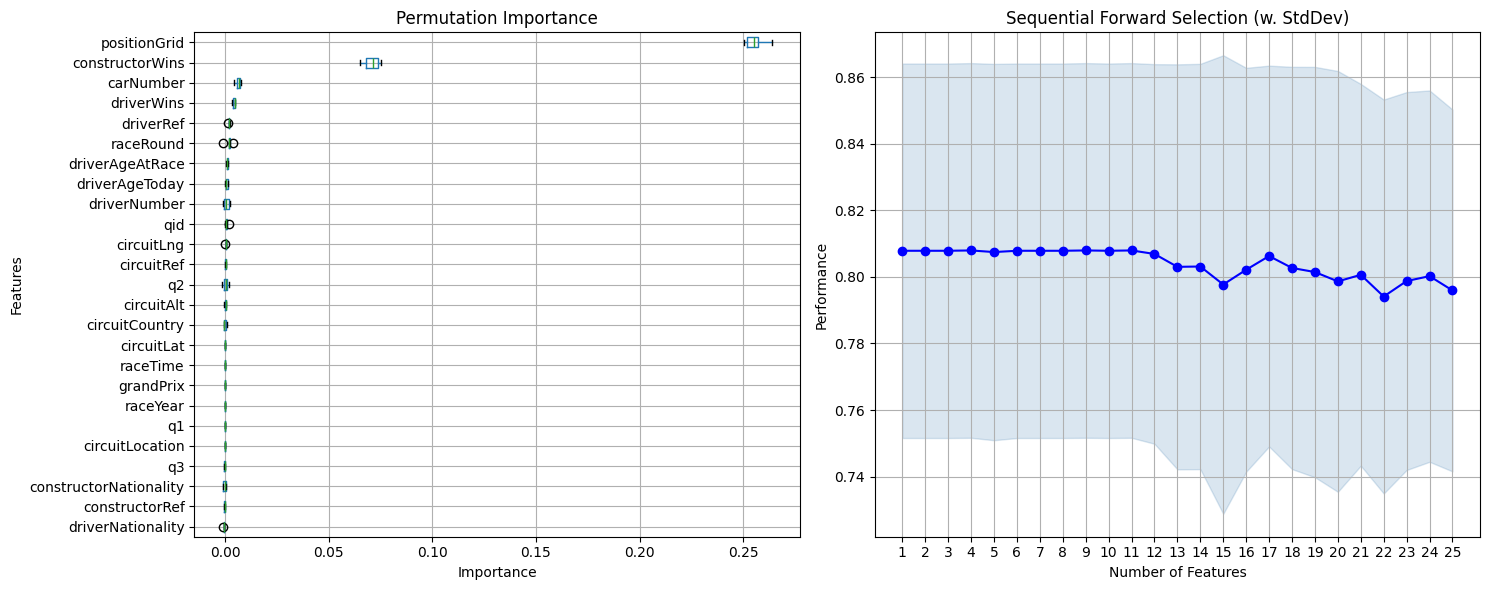

In [4]:
xgbr = XGBRegressor(
    objective="reg:linear",
    subsample=0.75,
    reg_lambda=3,
    reg_alpha=0,
    n_estimators=150,
    min_child_weight=200,
    max_depth=10,
    learning_rate=0.1,
    gamma=0.75,
    colsample_bytree=0.9,
)
scoring = make_scorer(balanced_accuracy_score)
model_selection(xgbr, X, y, tscv, scoring)

## XGBRanker


PI: 0.813 with (1, 3, 17, 18, 24) == ('constructorWins', 'driverNumber', 'driverWins',
	'positionGrid', 'qid')
SFS: 0.814 with (0, 1, 2, 4, 5, 6, 7, 8, 9, 23, 24) == ('carNumber', 'positionGrid',
	'driverRef', 'driverNationality', 'constructorRef', 'constructorNationality',
	'raceYear', 'raceRound', 'grandPrix', 'driverAgeAtRace', 'qid')
GA: 0.813 with (0, 1, 4, 18, 24) == ('carNumber', 'positionGrid', 'driverNationality',
	'constructorWins', 'qid')


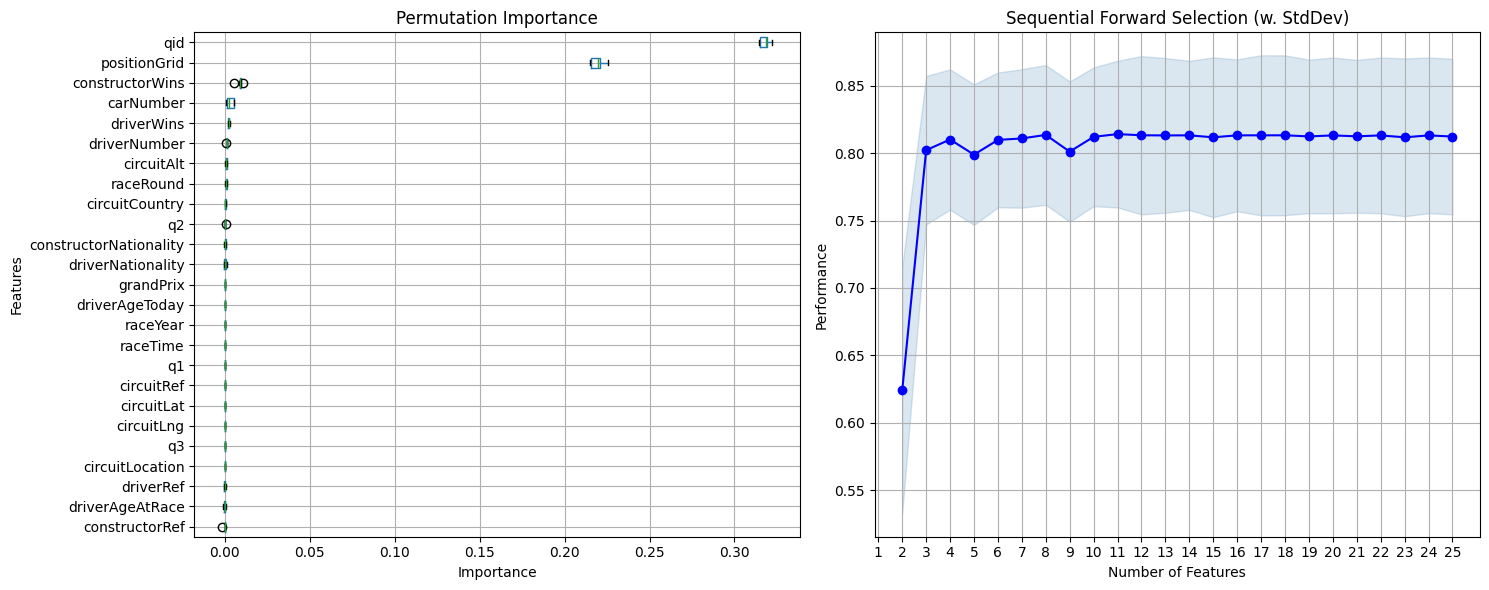

In [5]:
xgbk = XGBRanker(
    objective="rank:pairwise",
    subsample=0.9,
    reg_lambda=3,
    reg_alpha=10,
    n_estimators=75,
    min_child_weight=200,
    max_depth=5,
    learning_rate=0.01,
    gamma=0,
    colsample_bytree=0.75,
)
scoring = balanced_accuracy_ranker
model_selection(xgbk, X, y, tscv, scoring, rank=True)

## Results


Therefore, the selection for each algorithm are as follows

- XGBClassifier: 0.801 with ('carNumber', 'positionGrid', 'driverNumber', 'constructorRef', 'circuitLocation', 'constructorWins', 'q3', 'driverAgeAtRace')
- XGBRegressor: 0.808 with ('positionGrid', 'driverRef', 'driverNumber', 'constructorRef')
- XGBRanker: 0.814 with ('carNumber', 'positionGrid', 'driverRef', 'driverNationality', 'constructorRef', 'constructorNationality', 'raceYear', 'raceRound', 'grandPrix', 'driverAgeAtRace', 'qid')
